# Cài đặt thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Load data

In [2]:
columns = ['age', 'worklclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'class']

train_df_before = pd.read_csv(r'C:\Users\Hello\Documents\trien_khai_mo_hinh_hoc_may\Lab_2\data\adult.train', header=None, names=columns, na_values='?', skipinitialspace=True)
test_df_before = pd.read_csv(r'C:\Users\Hello\Documents\trien_khai_mo_hinh_hoc_may\Lab_2\data\adult.test', header=None, names=columns, na_values='?', skipinitialspace=True, comment='|' )

# EDA

In [3]:
#Khảo sát % giá trị thiếu trên train và test
missing_train = train_df_before.isnull().sum()
missing_percent_train = (missing_train / len(train_df_before)) * 100
missing_percent_train = missing_percent_train[missing_percent_train > 0]
print("Phần trăm giá trị thiếu trong train:")
print(missing_percent_train.sort_values(ascending=False))
missing_test = test_df_before.isnull().sum()
missing_percent_test = (missing_test / len(test_df_before)) * 100
missing_percent_test = missing_percent_test[missing_percent_test > 0]
print("Phần trăm giá trị thiếu trong test:")
print(missing_percent_test.sort_values(ascending=False))

Phần trăm giá trị thiếu trong train:
occupation        5.660146
worklclass        5.638647
native-country    1.790486
dtype: float64
Phần trăm giá trị thiếu trong test:
occupation        5.933296
worklclass        5.914870
native-country    1.682943
dtype: float64


### Giá trị thiếu chiếm phần trăm khá ít trong tập dữ liệu train và test -> Xử lý dữ liệu thiếu bằng cách xóa bỏ những hàng có dữ liệu thiếu

Tỷ lệ phần trăm nhãn trong train:
class
<=50K    75.919044
>50K     24.080956
Name: proportion, dtype: float64

Tỷ lệ phần trăm nhãn trong test:
class
<=50K.    76.377372
>50K.     23.622628
Name: proportion, dtype: float64


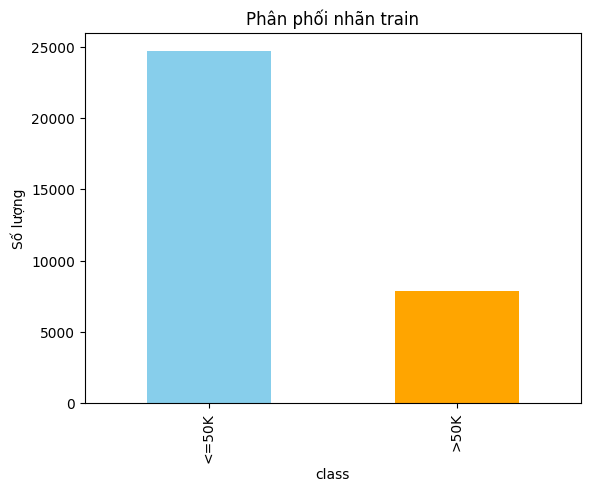

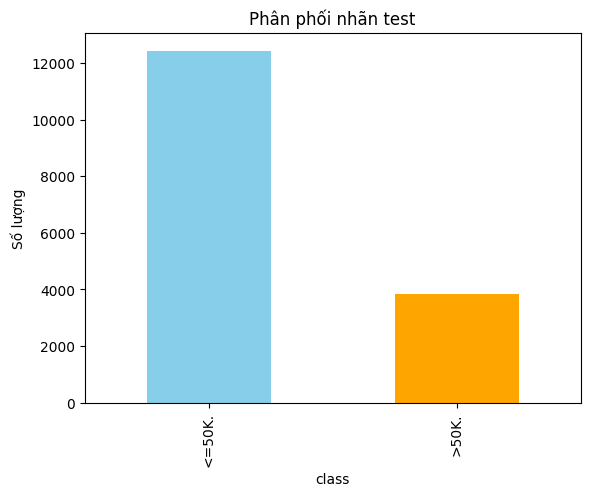

In [ ]:
train_ratio = train_df_before['class'].value_counts(normalize=True) * 100
test_ratio = test_df_before['class'].value_counts(normalize=True) * 100

print("Tỷ lệ phần trăm nhãn trong train:")
print(train_ratio)
print("\nTỷ lệ phần trăm nhãn trong test:")
print(test_ratio)

train_df_before['class'].value_counts().plot(kind='bar', title='Phân phối nhãn train', color=['skyblue','orange'])
plt.ylabel('Số lượng')
plt.show()

test_df_before['class'].value_counts().plot(kind='bar', title='Phân phối nhãn test', color=['skyblue','orange'])
plt.ylabel('Số lượng')
plt.show()


### Dữ liệu bị mất cân bằng -> SMOTE

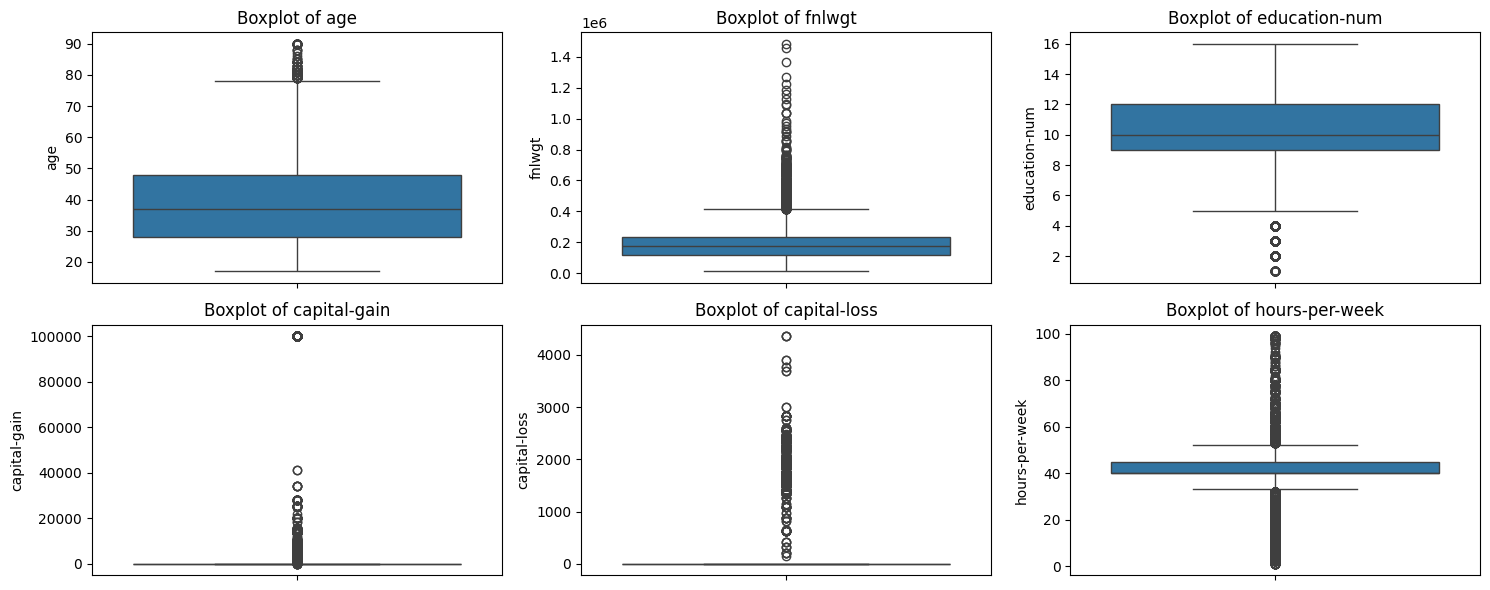

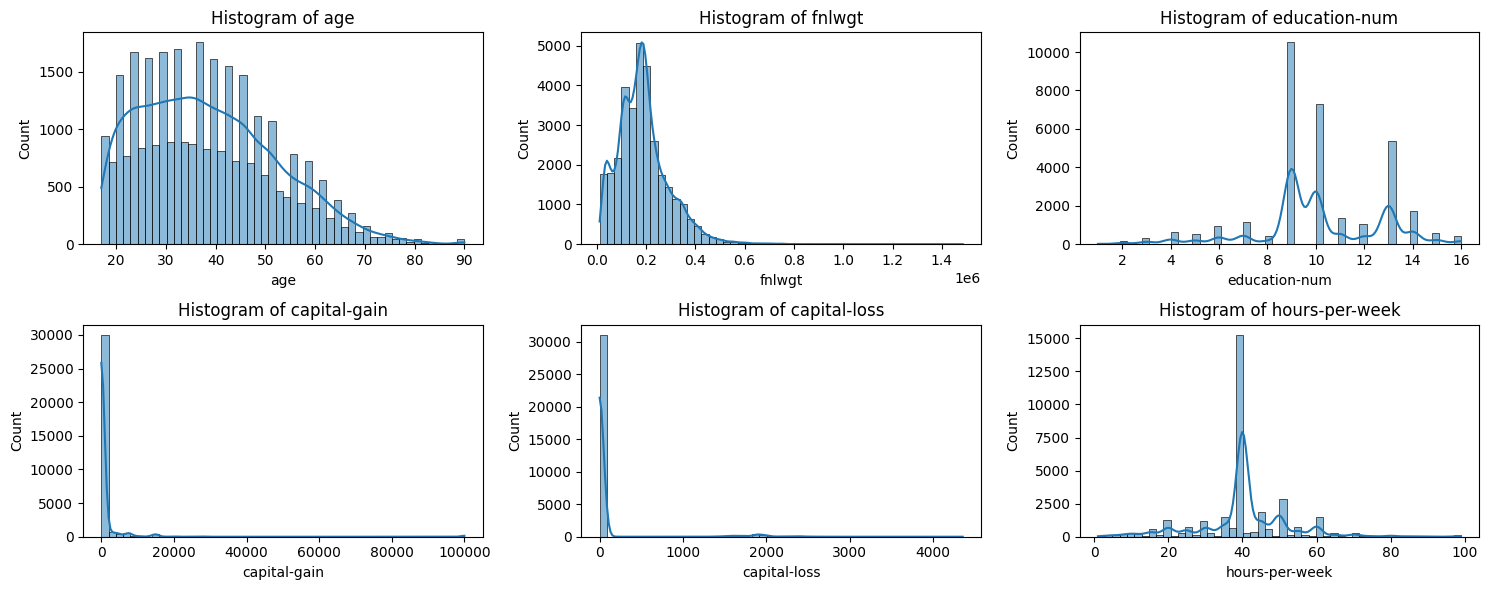

In [ ]:
num_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
plt.figure(figsize=(15, 6))
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=train_df_before[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()
plt.figure(figsize=(15, 6))
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(train_df_before[col], bins=50, kde=True)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()


#### Có 3 biến lệch khá nhiều là fnlwgt, capital-gain, capital-loss
- loại bỏ biến fnlwgt vì đây là trọng số mẫu do U.S. Census cung cấp, dùng để nhân số liệu mỗi cá nhân lên mức dân số thực tế, không phải đặc trưng cá nhân (như tuổi, học vấn, nghề nghiệp) mà chỉ là trọng số cho thống kê
- capital-gain, capital-loss -> log1p

# Data-Preprocessing

In [6]:
train_df = train_df_before.drop("fnlwgt", axis=1)
test_df = test_df_before.drop("fnlwgt", axis=1)

In [7]:
for df in [train_df_before, test_df_before]:
    df[:] = df.map(lambda x: x.strip() if isinstance(x, str) else x)
    df.dropna(inplace=True)
test_df_before['class'] = test_df_before['class'].str.replace('.', '', regex=False)

for df in [train_df, test_df]:
    df[:] = df.map(lambda x: x.strip() if isinstance(x, str) else x)
    df.dropna(inplace=True)
test_df['class'] = test_df['class'].str.replace('.', '', regex=False)

In [ ]:
train_df['capital-gain'] = np.log1p(train_df['capital-gain'])
train_df['capital-loss'] = np.log1p(train_df['capital-loss'])

test_df['capital-gain'] = np.log1p(test_df['capital-gain'])
test_df['capital-loss'] = np.log1p(test_df['capital-loss'])


In [9]:
# 3️⃣ Tách đặc trưng và nhãn
# Data chưa xử lý
X_train_raw = train_df_before.drop('class', axis=1)
y_train_raw = train_df_before['class']
X_test_raw = test_df_before.drop('class', axis=1)
y_test_raw = test_df_before['class']
# Data đã xử lý
X_train = train_df.drop('class', axis=1)
y_train = train_df['class']
X_test = test_df.drop('class', axis=1)
y_test = test_df['class']

## Raw

In [ ]:
X_train_raw_encoded = X_train_raw.copy()
X_test_raw_encoded = X_test_raw.copy()

label_encoders = {}

for col in X_train_raw_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train_raw_encoded[col] = le.fit_transform(X_train_raw_encoded[col])
    X_test_raw_encoded[col] = le.transform(X_test_raw_encoded[col])
    label_encoders[col] = le
    
y_train_raw_encoded = LabelEncoder().fit_transform(y_train_raw)
y_test_raw_encoded = LabelEncoder().fit_transform(y_test_raw)


## Preprocessed

In [16]:
cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols = X_train.select_dtypes(exclude=['object']).columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_test_cat = encoder.transform(X_test[cat_cols])

X_train_cat = pd.DataFrame(X_train_cat, columns=encoder.get_feature_names_out(cat_cols))
X_test_cat = pd.DataFrame(X_test_cat, columns=encoder.get_feature_names_out(cat_cols))

scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

X_train_num = pd.DataFrame(X_train_num, columns=num_cols)
X_test_num = pd.DataFrame(X_test_num, columns=num_cols)

X_train_final = pd.concat([X_train_num.reset_index(drop=True),
                           X_train_cat.reset_index(drop=True)], axis=1)

X_test_final = pd.concat([X_test_num.reset_index(drop=True),
                          X_test_cat.reset_index(drop=True)], axis=1)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [12]:
# Xử lý imbalance data
print("Nhãn trước SMOTE:")
print(pd.Series(y_train_encoded).value_counts())

smote = SMOTE(sampling_strategy=0.6,random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train_encoded)

unique, counts = np.unique(y_train_resampled, return_counts=True)
print("\nNhãn sau SMOTE:")
for label, count in zip(unique, counts):
    print(f"  {label_encoder.inverse_transform([label])[0]} : {count}")


Nhãn trước SMOTE:
0    22654
1     7508
Name: count, dtype: int64

Nhãn sau SMOTE:
  <=50K : 22654
  >50K : 13592


# Modeling

In [13]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model", is_raw = False, plot_cm=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if is_raw:
        pos = ">50K" 
    else:
        pos = 1  

    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, pos_label=pos)
    rec = recall_score(y_test, y_pred, pos_label=pos)
    f1 = f1_score(y_test, y_pred, pos_label=pos)
    cm = confusion_matrix(y_test, y_pred)

    print(model_name)
    print("Accuracy:", acc)
    print("Precision:", pre)
    print("Recall:", rec)
    print("F1 score", f1)

    if plot_cm:
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[0,1], yticklabels=[0,1])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"{model_name} Confusion Matrix")
        plt.show()

    return acc, pre, rec, f1, cm

## Raw data

Gradient Boosting(raw)
Accuracy: 0.8683266932270917
Precision: 0.7853107344632768
Recall: 0.6386486486486487
F1 score 0.7044268892532419


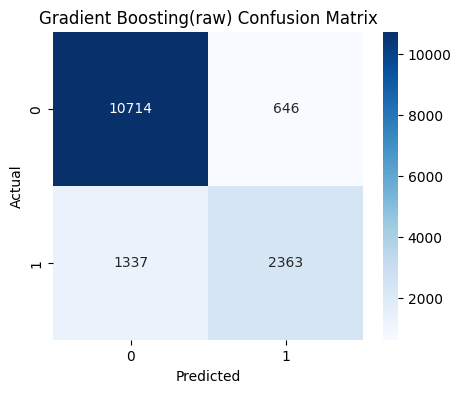

SVM(raw)
Accuracy: 0.7908366533864541
Precision: 0.967687074829932
Recall: 0.1537837837837838
F1 score 0.2653917910447761


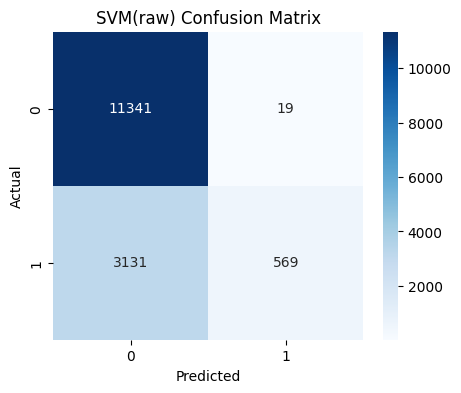

Decision Tree(raw)
Accuracy: 0.801195219123506
Precision: 0.5924083769633508
Recall: 0.6116216216216216
F1 score 0.6018617021276595


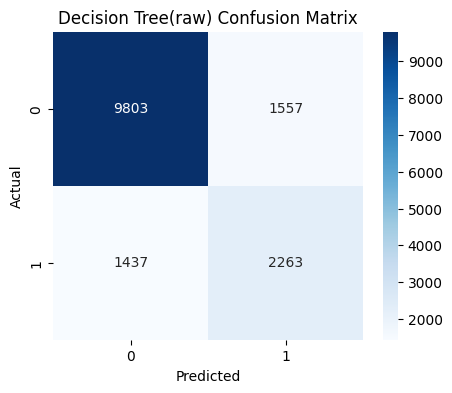

In [14]:
models_raw = {
    "Gradient Boosting(raw)": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42),
    "SVM(raw)": SVC(kernel="rbf"),
    "Decision Tree(raw)": DecisionTreeClassifier(random_state=42)
}

results_raw = {}

for name, model in models_raw.items():
    results_raw[name] = evaluate_model(model, X_train_raw_encoded, y_train_raw, X_test_raw_encoded, y_test_raw, name, is_raw=True)

## Preprocessed

Gradient Boosting(clean)
Accuracy: 0.8562416998671979
Precision: 0.6984742694595294
Recall: 0.73
F1 score 0.7138892559799128


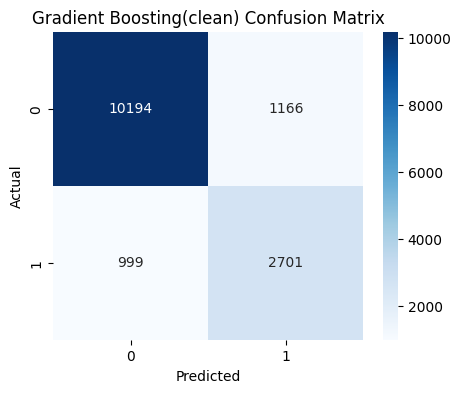

SVM (clean)
Accuracy: 0.8372509960159362
Precision: 0.6442596442596442
Recall: 0.7537837837837837
F1 score 0.6947315979574044


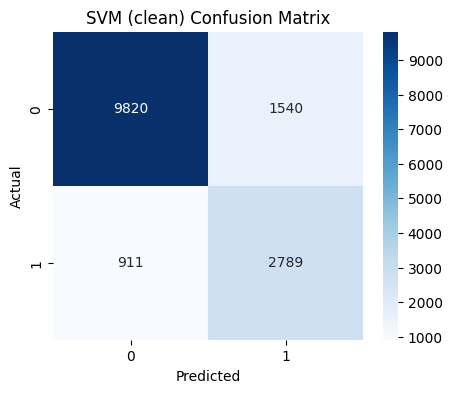

Decision Tree(clean)
Accuracy: 0.8132138114209827
Precision: 0.6198972695323061
Recall: 0.6197297297297297
F1 score 0.619813488309231


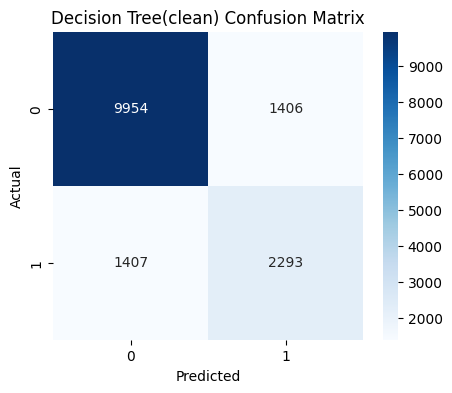

In [15]:
models_clean = {
    "Gradient Boosting(clean)": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42),
    "SVM (clean)": SVC(kernel="rbf"),
    "Decision Tree(clean)": DecisionTreeClassifier(random_state=42)
}

results_clean = {}

for name, model in models_clean.items():
    results_clean[name] = evaluate_model(model, X_train_resampled, y_train_resampled, X_test_final, y_test_encoded, name, is_raw=False)